<h1><center> Linear Models </center></h1>

<center>As first we will focus on the per race model , while as last we will run the linear part for the unseen circuit</center>

In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import os 
from matplotlib import pyplot as plt


<h1><center>Per-Race  </center></h1>

In [2]:

# Load the filtered final dataset
print("Loading Filtered_final.xlsx...")
df_merged = pd.read_excel('csv_output/Filtered_Data/Filtered_final.xlsx')
print(f"Loaded dataset shape: {df_merged.shape}")
print(f"Columns: {df_merged.columns.tolist()}")

df = df_merged.copy()

# Stable identifiers

df['race_id'] = (
    df['year'].astype(str) + '_' +
    df['round'].astype(str) + '_' +
    df['Grand_Prix'].astype(str)
)

group_cols = ['race_id', 'RacingNumber', 'Stint']

# Choose the best time column available inside a stint
time_col = 'LapInStint' if 'LapInStint' in df.columns else 'lap_number'

# Sort so splits are strictly chronological inside each driver-stint
df = df.sort_values(group_cols + [time_col]).reset_index(drop=True)


# 2) Time-ordered 70/15/15 split inside each (race, driver, stint)
#    - For very short stints, we don't create a test slice

MIN_TEST = 3   # minimum laps we want in test if we create a test segment
MIN_VAL  = 2   # minimum laps we want in val if we create a val segment
MIN_SPLIT_N = 10  # below this, keep in train (or train+val), avoid tiny test

def assign_time_split(g: pd.DataFrame) -> pd.DataFrame:
    n = len(g)

    # Too short -> keep it in train (avoids unstable tiny val/test)
    if n < MIN_SPLIT_N:
        g['split'] = 'train'
        return g

    # nominal cut points
    i1 = int(np.floor(0.70 * n))
    i2 = int(np.floor(0.85 * n))

    # enforce minimum sizes
    # ensure test has at least MIN_TEST
    i2 = min(i2, n - MIN_TEST)
    # ensure val has at least MIN_VAL
    i1 = min(i1, i2 - MIN_VAL)

    # ensure train has at least 1
    i1 = max(1, i1)
    # ensure val non-empty
    i2 = max(i1 + 1, i2)

    split = np.array(['train'] * n, dtype=object)
    split[i1:i2] = 'val'
    split[i2:] = 'test'
    g['split'] = split
    return g

df_with_split = df.groupby(group_cols, group_keys=False).apply(assign_time_split)

df_train = df_with_split[df_with_split['split'] == 'train'].drop(columns=['split']).copy()
df_val   = df_with_split[df_with_split['split'] == 'val'].drop(columns=['split']).copy()
df_test  = df_with_split[df_with_split['split'] == 'test'].drop(columns=['split']).copy()


# Reporting

total = len(df_with_split)
print("Overall split (laps):")
print(f"  Train: {len(df_train)} ({len(df_train)/total*100:.1f}%)")
print(f"  Val:   {len(df_val)} ({len(df_val)/total*100:.1f}%)")
print(f"  Test:  {len(df_test)} ({len(df_test)/total*100:.1f}%)")

# How many groups were too short and went fully to train?
group_sizes = df_with_split.groupby(group_cols).size()
print(f"\nDriver-stint groups total: {len(group_sizes)}")
print(f"Groups with n < {MIN_SPLIT_N} put fully in train: {(group_sizes < MIN_SPLIT_N).sum()}")


# HARD sanity checks (these catch subtle bugs)


# A) Contiguity check: splits must be contiguous blocks (train -> val -> test)
def is_noncontiguous(s):
    # if labels change more times than the number of unique labels, it's non-contiguous
    changes = (s != s.shift()).sum()
    return changes > s.nunique()

bad_contig = (df_with_split.groupby(group_cols)['split'].apply(is_noncontiguous))
print("\nAny non-contiguous split blocks within a driver-stint group?:", bad_contig.any())

# B) Time monotonicity check inside each group
bad_time = (df_with_split.groupby(group_cols)[time_col].apply(lambda s: not s.is_monotonic_increasing))
print("Any non-monotonic time ordering inside a driver-stint group?:", bad_time.any())


# C) "Future in train" check: max train time should be <= min val time, etc.
def boundary_ok(g):
    t = g.loc[g['split']=='train', time_col]
    v = g.loc[g['split']=='val', time_col]
    te = g.loc[g['split']=='test', time_col]
    ok = True
    if len(v) > 0 and len(t) > 0:
        ok &= (t.max() <= v.min())
    if len(te) > 0 and len(v) > 0:
        ok &= (v.max() <= te.min())
    if len(te) > 0 and len(t) > 0 and len(v) == 0:
        ok &= (t.max() <= te.min())
    return ok

bad_boundary = ~(df_with_split.groupby(group_cols).apply(boundary_ok))
print("Any boundary violations (train after val/test)?:", bad_boundary.any())


# Remove race_id before saving (only needed for splitting logic)
df_train = df_train.drop(columns=['race_id'])
df_val = df_val.drop(columns=['race_id'])
df_test = df_test.drop(columns=['race_id'])


# Save

df_train.to_excel('csv_output/Train_set_per_race.xlsx', index=False)
df_val.to_excel('csv_output/Validation_set_per_race.xlsx', index=False)
df_test.to_excel('csv_output/Test_set_per_race.xlsx', index=False)



Loading Filtered_final.xlsx...
Loaded dataset shape: (40396, 30)
Columns: ['year', 'round', 'name', 'Grand_Prix', 'Name', 'RacingNumber', 'Team', 'lap_number', 'Position', 'is_leader', 'in_drs_range', 'in_clean_air', 'in_dirty_air', 'pushing', 'Compound', 'Stint', 'TyreLife', 'TyreAgeAtStart', 'LapTime_next', 'delta_laptime', 'cumulative_degradation', 'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindSpeed', 'WindDirection', 'wind_sin', 'wind_cos', 'laptime_rolling_std_3']
Overall split (laps):
  Train: 28425 (70.4%)
  Val:   5388 (13.3%)
  Test:  6583 (16.3%)

Driver-stint groups total: 2869
Groups with n < 10 put fully in train: 1019

Any non-contiguous split blocks within a driver-stint group?: False
Any non-monotonic time ordering inside a driver-stint group?: False
Any boundary violations (train after val/test)?: False


In [3]:

print(f"\nCreating synthetic features...")
for df_split in [df_train, df_val, df_test]:
    df_split['is_new_tyre'] = (df_split['TyreAgeAtStart'] == 0).astype(int)
print(f"   is_new_tyre created (1=fresh, 0=used)")


Creating synthetic features...
   is_new_tyre created (1=fresh, 0=used)


In [4]:

# CONFIG & FEATURE SETS

TARGET = "LapTime_next"

NUM_FEATS_FULL = [
    "lap_number",
    "TyreLife",
    "TyreAgeAtStart",
    "is_leader",
    "in_drs_range",
    "in_clean_air",
    "in_dirty_air",
    "pushing",
    "AirTemp",
    "Humidity",
    "Pressure",
    "TrackTemp",
    #"WindSpeed",
    "wind_sin",
    "wind_cos",
    "delta_laptime",
    "cumulative_degradation",
    "laptime_rolling_std_3"
]

CAT_FEATS_FULL = ["RacingNumber", "Team", "Compound"]

# Define feature sets for comparison
FEATURE_SETS = {
    "Tyre+Stint": {
        "num": [
            "lap_number",
            "TyreLife",
            "TyreAgeAtStart"
        ],
        "cat": ["Compound"]
    },
    
    "Tyre+Stint+Weather": {
        "num": [
            "lap_number",
            "TyreLife",
            "TyreAgeAtStart",
            "AirTemp",
            "Humidity",
            "Pressure",
            "TrackTemp",
            #"WindSpeed",
            "wind_sin",
            "wind_cos"
        ],
        "cat": ["Compound"]
    },
    
    "Full (No Driver/Team)": {
        "num": NUM_FEATS_FULL,
        "cat": ["Compound"]  # Only tyre compound, NO driver/team
    },
    
    "Full (Driver+Team+Compound)": {
        "num": NUM_FEATS_FULL,
        "cat": CAT_FEATS_FULL  # Includes RacingNumber, Team, Compound
    }
}

# Validation - only require WindDirection if needed
for name, cfg in FEATURE_SETS.items():
    all_cols = cfg["num"] + cfg["cat"] + ["year", "round", TARGET]
    # Only require WindDirection if wind features are used
    if ("wind_sin" in cfg["num"]) or ("wind_cos" in cfg["num"]):
        all_cols += ["WindDirection"]
    for c in all_cols:
        if c not in df_train.columns:
            raise ValueError(f"Missing column in df_train: {c} (needed for {name})")


# FEATURE PREP

def add_wind_trig(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    theta = np.deg2rad(d["WindDirection"].astype(float))
    d["wind_sin"] = np.sin(theta)
    d["wind_cos"] = np.cos(theta)
    return d

def make_Xy(df: pd.DataFrame, num_feats, cat_feats, fit_cols=None, medians=None):
    """Make X, y matrices with dynamic feature selection."""
    # Only compute wind trig if wind features are used
    need_wind = ("wind_sin" in num_feats) or ("wind_cos" in num_feats)
    d = add_wind_trig(df) if need_wind else df.copy()

    # keep only needed columns
    X_raw = d[num_feats + cat_feats].copy()
    y = d[TARGET].astype(float).copy()

    # one-hot categorical
    X = pd.get_dummies(X_raw, columns=cat_feats, drop_first=True)

    # align columns to training set if provided
    if fit_cols is not None:
        X = X.reindex(columns=fit_cols, fill_value=0)

    # impute using provided medians if available, otherwise compute from X (train only)
    if medians is None:
        medians = X.median(numeric_only=True)
    X = X.fillna(medians)

    # drop NaN target rows
    m = y.notna()
    return X.loc[m], y.loc[m], medians


# TRAIN ONE MODEL PER RACE FOR A GIVEN FEATURE SET

def train_race_models(df_train, num_feats, cat_feats, model_type="linear", alpha=1.0, min_samples=None):
    """
    Train race-specific models for given features.
    
        Parameters
        ----------
    df_train : pd.DataFrame
        Training data
    num_feats : list
        Numerical features
    cat_feats : list
        Categorical features
    model_type : str
        "linear" for LinearRegression or "ridge" for Ridge
    alpha : float
        Regularization strength (only for Ridge)
    min_samples : int
        Minimum samples to train a race model. If None, use 100 or 5x num features.
    """
    # Auto-calculate min_samples if not provided
    if min_samples is None:
        n_features = len(num_feats) + len(cat_feats)
        min_samples = max(100, 5 * n_features)
    
    models = {}

    for (y_, r_), d_race in df_train.groupby(["year", "round"]):
        if len(d_race) < min_samples:
            continue

        Xtr, ytr, med = make_Xy(d_race, num_feats, cat_feats)
        if len(Xtr) < min_samples:
            continue

        # Choose model type
        if model_type == "ridge":
            model = Ridge(alpha=alpha)
        else:
            model = LinearRegression()
        
        model.fit(Xtr, ytr)

        models[(int(y_), int(r_))] = {
            "model": model,
            "cols": Xtr.columns,
            "med": med,
        }

    return models


# PREDICT & EVALUATE

def eval_feature_set(df_test, models, num_feats, cat_feats, name="model"):
    """Evaluate a feature set on test data, with coverage reporting."""
    preds, trues = [], []
    covered_races = 0
    total_races = df_test.groupby(["year", "round"]).ngroups

    for (y_, r_), d_race in df_test.groupby(["year", "round"]):
        key = (int(y_), int(r_))
        if key not in models:
            continue

        covered_races += 1
        fit = models[key]
        X, y, _ = make_Xy(d_race, num_feats, cat_feats,
                          fit_cols=fit["cols"], medians=fit["med"])
        yhat = fit["model"].predict(X)

        preds.append(yhat)
        trues.append(y.values)

    if not preds:
            return None
        
    yhat = np.concatenate(preds)
    ytrue = np.concatenate(trues)

    return {
        "model": name,
        "MAE": mean_absolute_error(ytrue, yhat),
        "RMSE": np.sqrt(mean_squared_error(ytrue, yhat)),
        "R2": r2_score(ytrue, yhat),
        "n_samples": len(yhat),
        "n_races_trained": len(models),
        "n_races_covered": covered_races,
        "test_race_coverage": f"{covered_races}/{total_races}"
    }


# RUN COMPARISON: LINEAR BASELINES + RIDGE ON FULL MODEL ONLY

print("="*100)
print("RACE-SPECIFIC MODELS: LINEAR BASELINES + OPTIMIZED RIDGE (Full Model Only)")
print("Step 1: Train LINEAR models on ALL feature sets")
print("Step 2: Optimize RIDGE alphas on FULL model only using VAL")
print("Step 3: Report best result")
print("="*100)

all_models_all = {}  # Store all trained models
test_results = []

# PHASE 1: Train LINEAR models on all feature sets

print("\nPhase 1: Training LINEAR baselines...\n")

for feature_name, cfg in FEATURE_SETS.items():
    print(f"[{feature_name}]", end=" ")
    
    # Train linear
    models = train_race_models(df_train, cfg["num"], cfg["cat"], 
                               model_type="linear", alpha=None)
    
    model_key = f"{feature_name} + Linear"
    all_models_all[model_key] = models
    
    print(f"✓ {len(models)} races", end="")
    
    # Eval on test
    test_res = eval_feature_set(df_test, models, cfg["num"], cfg["cat"], model_key)
    if test_res:
        print(f" | Test MAE: {test_res['MAE']:.4f}s")
        test_results.append(test_res)


# PHASE 2: Optimize Ridge ONLY on Full (Driver/Team model

print(f"\n{'─'*100}")
print("Phase 2: Optimizing RIDGE alphas on Full (No Driver/Team) model only...\n")

full_cfg = FEATURE_SETS["Full (Driver+Team+Compound)"]
ridge_alphas = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
val_results_ridge = {}

for alpha in ridge_alphas:
    print(f"[Ridge α={alpha}]", end=" ")
    
    # Train ridge
    models = train_race_models(df_train, full_cfg["num"], full_cfg["cat"], 
                               model_type="ridge", alpha=alpha)
    
    model_key = f"Full (Driver+Team+Compound) + Ridge (α={alpha})"
    all_models_all[model_key] = models
    
    print(f"✓ {len(models)} races", end="")
    
    # Eval on val
    val_res = eval_feature_set(df_val, models, full_cfg["num"], full_cfg["cat"], model_key)
    if val_res:
        val_mae = val_res['MAE']
        val_results_ridge[alpha] = val_mae
        print(f" | Val MAE: {val_mae:.4f}s")

# Select best alpha
best_alpha = min(val_results_ridge, key=val_results_ridge.get)
best_val_mae = val_results_ridge[best_alpha]

print(f"\n✓ Best α on VAL: {best_alpha} (MAE: {best_val_mae:.4f}s)")

# Train best ridge model and evaluate on test
print(f"\n{'─'*100}")
print(f"Phase 3: Testing best Ridge model...\n")

best_models = train_race_models(df_train, full_cfg["num"], full_cfg["cat"], 
                                model_type="ridge", alpha=best_alpha)

best_model_key = f"Full (Driver+Team+Compound) + Ridge (α={best_alpha})"
test_res_best = eval_feature_set(df_test, best_models, full_cfg["num"], full_cfg["cat"], best_model_key)

if test_res_best:
    print(f"\n{best_model_key}")
    print(f"  [Val]  MAE: {best_val_mae:.4f}s")
    print(f"  [Test] MAE: {test_res_best['MAE']:.4f}s, RMSE: {test_res_best['RMSE']:.4f}s, R²: {test_res_best['R2']:.4f}")
    test_results.append(test_res_best)


# SUMMARY

print("\n" + "="*100)
print("FINAL RESULTS (TEST SET)")
print("="*100 + "\n")

if test_results:
    results_df = pd.DataFrame(test_results).sort_values("MAE")
    print(results_df[["model", "MAE", "RMSE", "R2", "n_samples", "test_race_coverage"]].to_string(index=False))
    
    print(f"\n✓ BEST MODEL: {results_df.iloc[0]['model']}")
    print(f"  Test MAE: {results_df.iloc[0]['MAE']:.4f}s")
    print(f"  Test RMSE: {results_df.iloc[0]['RMSE']:.4f}s")
    print(f"  Test R²: {results_df.iloc[0]['R2']:.4f}")

# Store best model info for feature importance analysis
best_model_key_final = best_model_key

RACE-SPECIFIC MODELS: LINEAR BASELINES + OPTIMIZED RIDGE (Full Model Only)
Step 1: Train LINEAR models on ALL feature sets
Step 2: Optimize RIDGE alphas on FULL model only using VAL
Step 3: Report best result

Phase 1: Training LINEAR baselines...

[Tyre+Stint] ✓ 64 races | Test MAE: 0.6506s
[Tyre+Stint+Weather] ✓ 64 races | Test MAE: 0.6981s
[Full (No Driver/Team)] ✓ 64 races | Test MAE: 0.6044s
[Full (Driver+Team+Compound)] ✓ 64 races | Test MAE: 0.4251s

────────────────────────────────────────────────────────────────────────────────────────────────────
Phase 2: Optimizing RIDGE alphas on Full (No Driver/Team) model only...

[Ridge α=0.01] ✓ 64 races | Val MAE: 0.3310s
[Ridge α=0.1] ✓ 64 races | Val MAE: 0.3301s
[Ridge α=0.5] ✓ 64 races | Val MAE: 0.3282s
[Ridge α=1.0] ✓ 64 races | Val MAE: 0.3275s
[Ridge α=2.0] ✓ 64 races | Val MAE: 0.3277s
[Ridge α=5.0] ✓ 64 races | Val MAE: 0.3319s
[Ridge α=10.0] ✓ 64 races | Val MAE: 0.3406s

✓ Best α on VAL: 1.0 (MAE: 0.3275s)

────────────────

<h1><center> Per-Circuit</center></h1>

In [5]:
##########################################################
# SECTION 2: PER-CIRCUIT MODELS (with circuit geometry)
###########################################################

print("\n" + "="*100)
print("LOADING DATA FOR PER-CIRCUIT MODELS")
print("="*100)

# Load the filtered dataset WITH circuit geometry
print("\nLoading Filtered_04_with_circuit_geometry.xlsx...")
df_merged = pd.read_excel('csv_output/Filtered_Data/Filtered_04_with_circuit_geometry.xlsx')
print(f"Loaded dataset shape: {df_merged.shape}")
print(f"Columns: {df_merged.columns.tolist()}")



LOADING DATA FOR PER-CIRCUIT MODELS

Loading Filtered_04_with_circuit_geometry.xlsx...
Loaded dataset shape: (40396, 43)
Columns: ['year', 'round', 'name', 'Grand_Prix', 'type', 'Name', 'RacingNumber', 'Team', 'lap_number', 'Position', 'is_leader', 'in_drs_range', 'in_clean_air', 'in_dirty_air', 'pushing', 'Compound', 'Stint', 'TyreLife', 'TyreAgeAtStart', 'LapTime_next_vs_stint_baseline', 'delta_laptime', 'cumulative_degradation', 'LapTime', 'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindSpeed', 'wind_sin', 'wind_cos', 'laptime_rolling_std_3', 'num_drs_zones', 'num_turns', 'slow_share', 'slow_cluster_max', 'straight_ratio', 'straight_len_max_m', 'n_major_straights', 'heavy_braking_zones', 'heavy_braking_mean_dv_kmh', 'hb_at_end_of_max', 'avg_corner_angle', 'drs_total_len_m']


In [6]:

df = df_merged.copy()

# IDs

df["circuit_id"] = df["name"].astype(str)

# circuit-disjoint split (row-balanced)
#    - No circuit appears in more than one split
#    - Roughly 70/15/15 by number of rows (laps)

counts = df.groupby("circuit_id").size().sort_values(ascending=False)
total = counts.sum()

targets = {"train": 0.7 * total, "val": 0.15 * total, "test": 0.15 * total}
bins = {"train": set(), "val": set(), "test": set()}
bin_counts = {"train": 0, "val": 0, "test": 0}

rng = np.random.default_rng(42)
circuits = counts.index.to_list()
rng.shuffle(circuits)

for circuit in circuits:
    c = counts.loc[circuit]
    best_bin = min(bins.keys(), key=lambda k: bin_counts[k] / targets[k])
    bins[best_bin].add(circuit)
    bin_counts[best_bin] += c

df_train = df[df["circuit_id"].isin(bins["train"])].copy()
df_val   = df[df["circuit_id"].isin(bins["val"])].copy()
df_test  = df[df["circuit_id"].isin(bins["test"])].copy()


# sanity checks

train_c = set(df_train["circuit_id"].unique())
val_c   = set(df_val["circuit_id"].unique())
test_c  = set(df_test["circuit_id"].unique())

assert train_c.isdisjoint(val_c),  " Train-Val circuit overlap!"
assert train_c.isdisjoint(test_c), " Train-Test circuit overlap!"
assert val_c.isdisjoint(test_c),   " Val-Test circuit overlap!"
print("✓ No circuit overlap across splits")

print("\nSplit sizes (rows):")
print(f"  Train: {len(df_train):,} ({len(df_train)/len(df)*100:.1f}%) | Circuits: {len(train_c)}")
print(f"  Val:   {len(df_val):,} ({len(df_val)/len(df)*100:.1f}%) | Circuits: {len(val_c)}")
print(f"  Test:  {len(df_test):,} ({len(df_test)/len(df)*100:.1f}%) | Circuits: {len(test_c)}")


#  Save

# Keep circuit_id column if you want debugging; otherwise drop it before saving:
df_train.drop(columns=["circuit_id"], inplace=True)
df_val.drop(columns=["circuit_id"], inplace=True)
df_test.drop(columns=["circuit_id"], inplace=True)

df_train.to_excel("csv_output/Train_set.xlsx", index=False)
df_val.to_excel("csv_output/Validation_set.xlsx", index=False)
df_test.to_excel("csv_output/Test_set.xlsx", index=False)

print("\n✓ Saved Train_set.xlsx, Validation_set.xlsx, Test_set.xlsx")

✓ No circuit overlap across splits

Split sizes (rows):
  Train: 26,221 (64.9%) | Circuits: 15
  Val:   7,199 (17.8%) | Circuits: 4
  Test:  6,976 (17.3%) | Circuits: 5

✓ Saved Train_set.xlsx, Validation_set.xlsx, Test_set.xlsx


In [7]:


# Create synthetic tyre feature 

print(f"\nCreating synthetic features...")
for df_split in [df_train, df_val, df_test]:
    df_split['is_new_tyre'] = (df_split['TyreAgeAtStart'] == 0).astype(int)
print(f"   is_new_tyre created (1=fresh, 0=used)")


# Define geometry columns (if not already defined from PCA section)
if "geom_cols" not in globals():
    geom_cols_all = [
        'num_drs_zones', 'length_m', 'num_turns',
        'slow_share', 'slow_cluster_max',
        'straight_ratio', 'straight_len_max_m', 'n_major_straights',
        'heavy_braking_zones', 'heavy_braking_mean_dv_kmh', 'hb_at_end_of_max',
        'avg_corner_angle', 'avg_corner_distance', 'drs_total_len_m'
    ]
    geom_cols = [col for col in geom_cols_all if col in df_train.columns]
    print(f"\nGeometry columns available: {len(geom_cols)}/{len(geom_cols_all)}")
    print(f"  Available: {geom_cols}")

TARGET = "LapTime_next_vs_stint_baseline"

assert "geom_cols" in globals(), "geom_cols not found. Run geometry step first."

# Blocks 

NUM_TYRE = ["is_new_tyre", "TyreLife", "TyreAgeAtStart"]

NUM_WEATHER = ["AirTemp", "Humidity", "Pressure", "TrackTemp", "wind_sin", "wind_cos"]

# keep only "safe" state features (avoid anything that might embed the target)
NUM_STATE = ["is_leader", "in_drs_range", "in_clean_air", "in_dirty_air", "pushing", 'laptime_rolling_std_3', 'delta_laptime', 'cumulative_degradation', 'LapTime']

# Geometry features (raw columns, not PCA)
# Excluding hb_at_end_of_max since it's boolean 
NUM_GEOMETRY = [col for col in geom_cols if col in df_train.columns and col != 'hb_at_end_of_max']

# Circuit identity as categorical feature 
CIRCUIT_CAT = []  # (not used in this model) as we are doing circuit-disjoint splits

# Driver and team as categorical features (driver skill + team effects)
DRIVER_TEAM_CAT = ["RacingNumber", "Team"]

CAT = ["Compound"] + DRIVER_TEAM_CAT


# Grid search alphas

ALPHAS_RIDGE = [0.1, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0]
ALPHAS_EN = [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]
L1RATIOS = [0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0]


# Helpers

def make_Xy(df, num_feats, cat_feats, target, fit_cols=None, medians=None):
    X_raw = df[num_feats + cat_feats].copy()
    y = df[target].astype(float).copy()

    X = pd.get_dummies(X_raw, columns=cat_feats, drop_first=True)

    if fit_cols is not None:
        X = X.reindex(columns=fit_cols, fill_value=0)

    if medians is None:
        medians = X.median(numeric_only=True)
    X = X.fillna(medians)

    m = y.notna()
    return X.loc[m], y.loc[m], X.columns, medians

def metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred),
    }

def fit_eval(model, num_feats, label):
    # train
    Xtr, ytr, cols, meds = make_Xy(df_train, num_feats, CAT, TARGET)
    model.fit(Xtr, ytr)

    # val
    Xva, yva, _, _ = make_Xy(df_val, num_feats, CAT, TARGET, fit_cols=cols, medians=meds)
    yva_hat = model.predict(Xva)

    # test
    Xte, yte, _, _ = make_Xy(df_test, num_feats, CAT, TARGET, fit_cols=cols, medians=meds)
    yte_hat = model.predict(Xte)

    return {
        "model": label,
        "n_features": Xtr.shape[1],
        "val": metrics(yva, yva_hat),
        "test": metrics(yte, yte_hat),
        "n_test": len(Xte),
    }


# NESTED FEATURE LADDER

FEAT_TYRE = NUM_TYRE
FEAT_TYRE_WEATHER = NUM_TYRE + NUM_WEATHER
FEAT_TYRE_WEATHER_STATE = NUM_TYRE + NUM_WEATHER + NUM_STATE
FEAT_TYRE_WEATHER_STATE_GEOM = NUM_TYRE + NUM_WEATHER + NUM_STATE + NUM_GEOMETRY

EXPERIMENTS = [
    ("1) Tyre (Linear)", LinearRegression(), FEAT_TYRE),
    ("2) Tyre+Weather (Linear)", LinearRegression(), FEAT_TYRE_WEATHER),
    ("3) Tyre+Weather+State (Linear)", LinearRegression(), FEAT_TYRE_WEATHER_STATE),
    ("4) Tyre+Weather+State+Geometry (Linear)", LinearRegression(), FEAT_TYRE_WEATHER_STATE_GEOM),
]

print("="*100)
print("CIRCUIT-BASED MODEL: nested blocks + raw geometry + GridSearchCV for optimal regularization")
print("="*100)

rows = []
for label, model, feats in EXPERIMENTS:
    res = fit_eval(model, feats, label)
    print(f"{label:<45} | Test MAE {res['test']['MAE']:.4f} | Test R² {res['test']['R2']:.4f} | p={res['n_features']}")
    rows.append({
        "model": res["model"],
        "p": res["n_features"],
        "val_MAE": res["val"]["MAE"],
        "val_R2": res["val"]["R2"],
        "test_MAE": res["test"]["MAE"],
        "test_RMSE": res["test"]["RMSE"],
        "test_R2": res["test"]["R2"],
        "n_test": res["n_test"],
    })


# Gridsearch CV for Ridge alpha on full features

print("\n" + "="*100)
print("Gridsearch CV: Finding optimal Ridge α for Tyre+Weather+State+Geometry")
print("="*100)

# Prepare data
Xtr, ytr, cols, meds = make_Xy(df_train, FEAT_TYRE_WEATHER_STATE_GEOM, CAT, TARGET)
Xva, yva, _, _ = make_Xy(df_val, FEAT_TYRE_WEATHER_STATE_GEOM, CAT, TARGET, fit_cols=cols, medians=meds)

# Grid search on validation set
print(f"\nTesting alphas: {ALPHAS_RIDGE}")
print(f"Train set: {Xtr.shape[0]} samples, {Xtr.shape[1]} features")
print(f"Val set:   {Xva.shape[0]} samples")

grid_results = []
for alpha in ALPHAS_RIDGE:
    ridge = Ridge(alpha=alpha)
    ridge.fit(Xtr, ytr)
    yva_hat = ridge.predict(Xva)
    
    mae = mean_absolute_error(yva, yva_hat)
    rmse = np.sqrt(mean_squared_error(yva, yva_hat))
    r2 = r2_score(yva, yva_hat)
    
    grid_results.append({
        "alpha": alpha,
        "val_MAE": mae,
        "val_RMSE": rmse,
        "val_R2": r2,
    })
    print(f"  α={alpha:7.1f}: Val MAE={mae:.4f}, Val RMSE={rmse:.4f}, Val R²={r2:.4f}")

# Find best alpha
grid_df = pd.DataFrame(grid_results)
best_idx = grid_df["val_MAE"].idxmin()
best_alpha = grid_df.loc[best_idx, "alpha"]
best_mae = grid_df.loc[best_idx, "val_MAE"]

print(f"\n✓ Best Alpha: {best_alpha:.1f} (Val MAE: {best_mae:.4f})")

# Train on full dataset + best alpha and evaluate on test
print(f"\nTraining final Ridge model with α={best_alpha:.1f} on full training data...")
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(Xtr, ytr)

Xte, yte, _, _ = make_Xy(df_test, FEAT_TYRE_WEATHER_STATE_GEOM, CAT, TARGET, fit_cols=cols, medians=meds)
yte_hat = ridge_best.predict(Xte)

best_ridge_metrics = metrics(yte, yte_hat)
print(f"  Test MAE:  {best_ridge_metrics['MAE']:.4f}")
print(f"  Test RMSE: {best_ridge_metrics['RMSE']:.4f}")
print(f"  Test R²:   {best_ridge_metrics['R2']:.4f}")

rows.append({
    "model": f"5) Tyre+Weather+State+Geometry (Ridge α={best_alpha:.1f}✓)",
    "p": Xtr.shape[1],
    "val_MAE": grid_df.loc[best_idx, "val_MAE"],
    "val_R2": grid_df.loc[best_idx, "val_R2"],
    "test_MAE": best_ridge_metrics["MAE"],
    "test_RMSE": best_ridge_metrics["RMSE"],
    "test_R2": best_ridge_metrics["R2"],
    "n_test": len(Xte),
})

# Gridsearch CV for Ridge alpha on TYRE+WEATHER+STATE

print("\n" + "="*100)
print("Gridsearch CV: Finding optimal Ridge α for Tyre+Weather+State")
print("="*100)

# Prepare data
Xtr_tws, ytr_tws, cols_tws, meds_tws = make_Xy(df_train, FEAT_TYRE_WEATHER_STATE, CAT, TARGET)
Xva_tws, yva_tws, _, _ = make_Xy(df_val, FEAT_TYRE_WEATHER_STATE, CAT, TARGET, fit_cols=cols_tws, medians=meds_tws)

# Grid search on validation set
print(f"\nTesting alphas: {ALPHAS_RIDGE}")
print(f"Train set: {Xtr_tws.shape[0]} samples, {Xtr_tws.shape[1]} features")
print(f"Val set:   {Xva_tws.shape[0]} samples")

grid_results_tws = []
for alpha in ALPHAS_RIDGE:
    ridge = Ridge(alpha=alpha)
    ridge.fit(Xtr_tws, ytr_tws)
    yva_hat = ridge.predict(Xva_tws)
    
    mae = mean_absolute_error(yva_tws, yva_hat)
    rmse = np.sqrt(mean_squared_error(yva_tws, yva_hat))
    r2 = r2_score(yva_tws, yva_hat)
    
    grid_results_tws.append({
        "alpha": alpha,
        "val_MAE": mae,
        "val_RMSE": rmse,
        "val_R2": r2,
    })
    print(f"  α={alpha:7.1f}: Val MAE={mae:.4f}, Val RMSE={rmse:.4f}, Val R²={r2:.4f}")

# Find best alpha
grid_df_tws = pd.DataFrame(grid_results_tws)
best_idx_tws = grid_df_tws["val_MAE"].idxmin()
best_alpha_tws = grid_df_tws.loc[best_idx_tws, "alpha"]
best_mae_tws = grid_df_tws.loc[best_idx_tws, "val_MAE"]

print(f"\n✓ Best Alpha: {best_alpha_tws:.1f} (Val MAE: {best_mae_tws:.4f})")

# Train on full dataset + best alpha and evaluate on test
print(f"\nTraining final Ridge model with α={best_alpha_tws:.1f} on full training data...")
ridge_best_tws = Ridge(alpha=best_alpha_tws)
ridge_best_tws.fit(Xtr_tws, ytr_tws)

Xte_tws, yte_tws, _, _ = make_Xy(df_test, FEAT_TYRE_WEATHER_STATE, CAT, TARGET, fit_cols=cols_tws, medians=meds_tws)
yte_hat_tws = ridge_best_tws.predict(Xte_tws)

best_ridge_metrics_tws = metrics(yte_tws, yte_hat_tws)
print(f"  Test MAE:  {best_ridge_metrics_tws['MAE']:.4f}")
print(f"  Test RMSE: {best_ridge_metrics_tws['RMSE']:.4f}")
print(f"  Test R²:   {best_ridge_metrics_tws['R2']:.4f}")

rows.append({
    "model": f"5a) Tyre+Weather+State (Ridge α={best_alpha_tws:.1f}✓)",
    "p": Xtr_tws.shape[1],
    "val_MAE": grid_df_tws.loc[best_idx_tws, "val_MAE"],
    "val_R2": grid_df_tws.loc[best_idx_tws, "val_R2"],
    "test_MAE": best_ridge_metrics_tws["MAE"],
    "test_RMSE": best_ridge_metrics_tws["RMSE"],
    "test_R2": best_ridge_metrics_tws["R2"],
    "n_test": len(Xte_tws),
})



# Gridsearch: Elastic Net (alpha, l1_ratio)

print("\n" + "="*100)
print("Gridsearch: Elastic Net (alpha, l1_ratio) on Tyre+Weather+State+Geometry")
print("="*100)

# Build raw matrices with your exact alignment
Xtr_raw, ytr_en, cols_en, meds_en = make_Xy(df_train, FEAT_TYRE_WEATHER_STATE_GEOM, CAT, TARGET)
Xva_raw, yva_en, _, _              = make_Xy(df_val,   FEAT_TYRE_WEATHER_STATE_GEOM, CAT, TARGET, fit_cols=cols_en, medians=meds_en)
Xte_raw, yte_en, _, _              = make_Xy(df_test,  FEAT_TYRE_WEATHER_STATE_GEOM, CAT, TARGET, fit_cols=cols_en, medians=meds_en)

# Scale using TRAIN only
scaler = StandardScaler()
Xtr_scaled = scaler.fit_transform(Xtr_raw)
Xva_scaled = scaler.transform(Xva_raw)
Xte_scaled = scaler.transform(Xte_raw)

best_en = {"val_MAE": np.inf, "alpha": None, "l1_ratio": None, "model": None, "val_R2": None}

print(f"\nTesting ElasticNet with {len(L1RATIOS)} l1_ratios × {len(ALPHAS_EN)} alphas = {len(L1RATIOS)*len(ALPHAS_EN)} combinations")
for l1 in L1RATIOS:
    for a in ALPHAS_EN:
        en = ElasticNet(alpha=a, l1_ratio=l1, max_iter=50000, tol=1e-4, random_state=42)
        en.fit(Xtr_scaled, ytr_en)
        yva_hat = en.predict(Xva_scaled)

        mae = mean_absolute_error(yva_en, yva_hat)
        r2  = r2_score(yva_en, yva_hat)

        if mae < best_en["val_MAE"]:
            best_en.update({"val_MAE": mae, "val_R2": r2, "alpha": a, "l1_ratio": l1, "model": en})

        print(f"  l1_ratio={l1:>4.2f} | alpha={a:>7.3g} | Val MAE={mae:.4f} | Val R²={r2:.4f}")

print(f"\n✓ Best ElasticNet: alpha={best_en['alpha']} | l1_ratio={best_en['l1_ratio']} | Val MAE={best_en['val_MAE']:.4f}")

# Test evaluation (once)
yte_hat_en = best_en["model"].predict(Xte_scaled)
en_test = metrics(yte_en, yte_hat_en)

n_nonzero = int(np.sum(best_en["model"].coef_ != 0))
print("\nElasticNet TEST:")
print(f"  Test MAE:  {en_test['MAE']:.4f}")
print(f"  Test RMSE: {en_test['RMSE']:.4f}")
print(f"  Test R²:   {en_test['R2']:.4f}")
print(f"  Non-zero coefficients: {n_nonzero}/{Xtr_raw.shape[1]}")

rows.append({
    "model": f"6) Tyre+Weather+State+Geometry (ElasticNet a={best_en['alpha']}, l1={best_en['l1_ratio']})",
    "p": Xtr_raw.shape[1],
    "val_MAE": best_en["val_MAE"],
    "val_R2": best_en["val_R2"],
    "test_MAE": en_test["MAE"],
    "test_RMSE": en_test["RMSE"],
    "test_R2": en_test["R2"],
    "n_test": len(Xte_raw),
})

print("\n" + "="*100)
print("SUMMARY (sorted by Test MAE)")
print("="*100)
summary = pd.DataFrame(rows).sort_values("test_MAE")
print(summary.to_string(index=False))  



Creating synthetic features...
   is_new_tyre created (1=fresh, 0=used)

Geometry columns available: 12/14
  Available: ['num_drs_zones', 'num_turns', 'slow_share', 'slow_cluster_max', 'straight_ratio', 'straight_len_max_m', 'n_major_straights', 'heavy_braking_zones', 'heavy_braking_mean_dv_kmh', 'hb_at_end_of_max', 'avg_corner_angle', 'drs_total_len_m']
CIRCUIT-BASED MODEL: nested blocks + raw geometry + GridSearchCV for optimal regularization
1) Tyre (Linear)                              | Test MAE 0.4533 | Test R² -0.1576 | p=48
2) Tyre+Weather (Linear)                      | Test MAE 0.4681 | Test R² -0.2075 | p=54
3) Tyre+Weather+State (Linear)                | Test MAE 0.3651 | Test R² 0.2386 | p=63
4) Tyre+Weather+State+Geometry (Linear)       | Test MAE 0.6581 | Test R² -0.8873 | p=74

Gridsearch CV: Finding optimal Ridge α for Tyre+Weather+State+Geometry

Testing alphas: [0.1, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0]
Train set: 26221 samples, 74 features
Val set:   7199

In [37]:


# Create output directory
LINEAR_OUTDIR = "csv_output/linear"
os.makedirs(LINEAR_OUTDIR, exist_ok=True)

# Get test indices from yte_tws (to align with raw test data)
test_mask = df_test[TARGET].notna()
df_test_valid = df_test.loc[test_mask].copy()

# Row-level predictions
df_predictions = df_test_valid[[
    'year', 'round', 'name', 'RacingNumber', 'Team', 
    'Compound', 'TyreLife', 'TrackTemp', 'Stint', 'lap_number'
]].copy()
df_predictions['y_true'] = yte_tws.values
df_predictions['y_pred'] = yte_hat_tws
df_predictions['residual'] = yte_tws.values - yte_hat_tws

predictions_path = os.path.join(LINEAR_OUTDIR, "linear_tws_test_predictions.csv")
df_predictions.to_csv(predictions_path, index=False)

# Per-circuit summary
per_circuit_list = []
for circuit in df_test_valid['name'].unique():
    mask = df_test_valid['name'] == circuit
    circuit_residuals = df_predictions.loc[mask, 'residual'].values
    circuit_mae = np.abs(circuit_residuals).mean()
    circuit_median_ae = np.median(np.abs(circuit_residuals))
    circuit_bias = circuit_residuals.mean()
    
    per_circuit_list.append({
        'Circuit': circuit,
        'n': mask.sum(),
        'MAE': circuit_mae,
        'median_AE': circuit_median_ae,
        'bias': circuit_bias
    })

df_per_circuit = pd.DataFrame(per_circuit_list).sort_values('MAE', ascending=False)
per_circuit_path = os.path.join(LINEAR_OUTDIR, "linear_tws_per_circuit.csv")
df_per_circuit.to_csv(per_circuit_path, index=False)

# Per-compound summary
per_compound_list = []
for compound in df_test_valid['Compound'].unique():
    mask = df_test_valid['Compound'] == compound
    compound_residuals = df_predictions.loc[mask, 'residual'].values
    compound_mae = np.abs(compound_residuals).mean()
    compound_bias = compound_residuals.mean()
    
    per_compound_list.append({
        'Compound': compound,
        'n': mask.sum(),
        'MAE': compound_mae,
        'bias': compound_bias
    })

df_per_compound = pd.DataFrame(per_compound_list).sort_values('MAE', ascending=False)
per_compound_path = os.path.join(LINEAR_OUTDIR, "linear_tws_per_compound.csv")
df_per_compound.to_csv(per_compound_path, index=False)

# Coefficients (Ridge, from Step 2)
coef_df = pd.DataFrame({
    'feature': cols_tws,
    'coefficient': ridge_best_tws.coef_
}).sort_values('coefficient', key=abs, ascending=False)

coefficients_path = os.path.join(LINEAR_OUTDIR, "linear_tws_coefficients.csv")
coef_df.to_csv(coefficients_path, index=False)

# Report summary
print("\nStep 2 Artifacts (Linear Baseline, Ridge α):")
print(f"  Saved: {os.path.basename(predictions_path)} ({len(df_predictions)} rows)")
print(f"  Saved: {os.path.basename(per_circuit_path)}")
print(f"  Saved: {os.path.basename(per_compound_path)}")
print(f"  Saved: {os.path.basename(coefficients_path)}")




Step 2 Artifacts (Linear Baseline, Ridge α):
  Saved: linear_tws_test_predictions.csv (6976 rows)
  Saved: linear_tws_per_circuit.csv
  Saved: linear_tws_per_compound.csv
  Saved: linear_tws_coefficients.csv


<h1><center> Interpretation</center></h1>

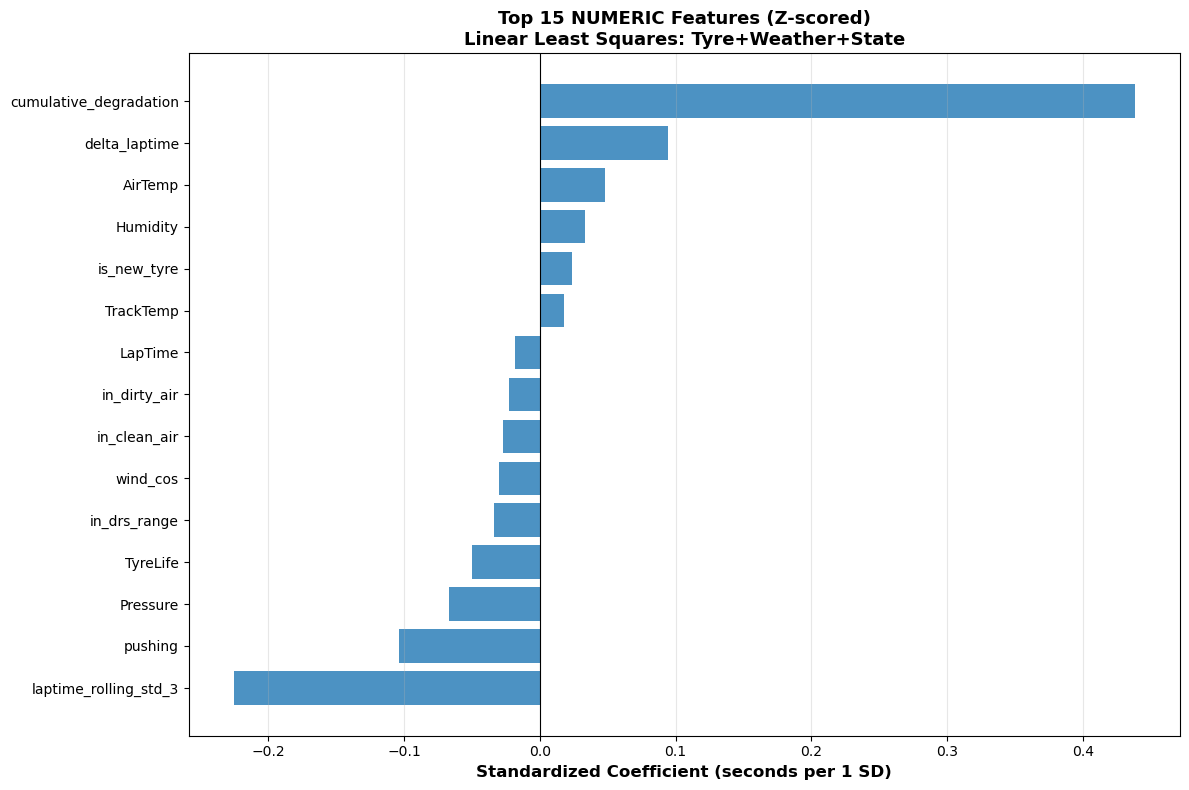

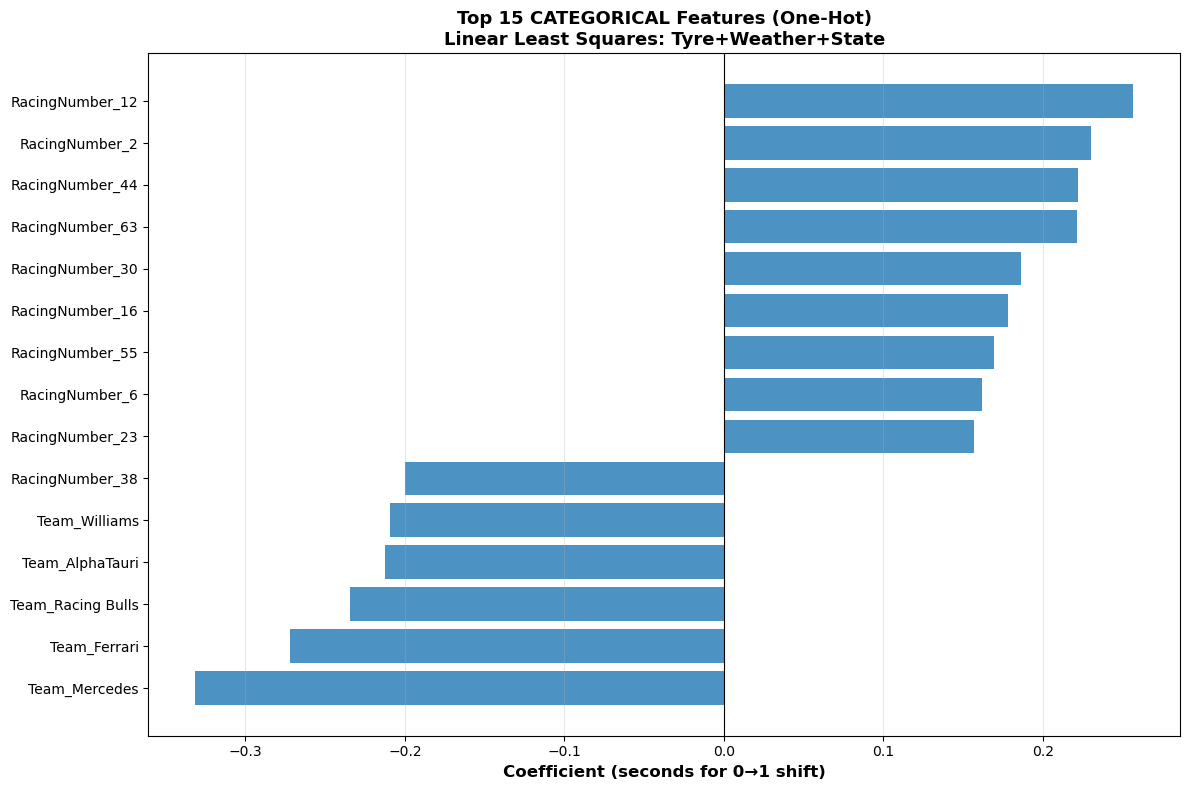


STEP 7 (Interpretability, Linear LS):
  Train (26221, 63) | Val (7199, 63) | Test (6976, 63)
  Features: numeric_z=18 | onehot_01=45
  Test: MAE=0.3651 | RMSE=0.5210 | R²=0.2386 | intercept=-0.1331
  Saved: linear_tws_coefficients_mixedscale.csv
  Saved: linear_tws_coefficients_top15_numeric.pdf
  Saved: linear_tws_coefficients_top15_categorical.pdf
  Key: numeric strongest = cumulative_degradation (+0.438s per 1 SD)
  Key: categorical strongest = Team_Mercedes (-0.331s vs baseline)
  Note: numeric vs categorical coefficients are on different scales (not comparable).


In [38]:

# Linear least squares (T+W+S): Standardized coefficients (numeric z-scored, one-hot 0/1)

# Rebuild design matrices
Xtr_interp, ytr_interp, cols_interp, meds_interp = make_Xy(
    df_train, FEAT_TYRE_WEATHER_STATE, CAT, TARGET
)
Xva_interp, yva_interp, _, _ = make_Xy(
    df_val, FEAT_TYRE_WEATHER_STATE, CAT, TARGET, 
    fit_cols=cols_interp, medians=meds_interp
)
Xte_interp, yte_interp, _, _ = make_Xy(
    df_test, FEAT_TYRE_WEATHER_STATE, CAT, TARGET, 
    fit_cols=cols_interp, medians=meds_interp
)

# Identify numeric vs categorical
numeric_feat_names = [c for c in (NUM_TYRE + NUM_WEATHER + NUM_STATE) if c in Xtr_interp.columns]
categorical_col_names = [c for c in Xtr_interp.columns if c not in numeric_feat_names]

# Check for missing or empty numeric features
missing_numeric = set(NUM_TYRE + NUM_WEATHER + NUM_STATE) - set(numeric_feat_names)
if missing_numeric:
    print(f"\n⚠ WARNING (Step 7): Missing numeric features: {sorted(missing_numeric)}")
if len(numeric_feat_names) == 0:
    print(f"\n⚠ WARNING (Step 7): No numeric features found. Check data preparation.")

# Standardize numeric only (using train stats)
means = Xtr_interp[numeric_feat_names].mean()
stds  = Xtr_interp[numeric_feat_names].std(ddof=0)
stds  = stds.replace(0, 1).fillna(1)

def standardize_numeric_df(X, col_names, means, stds):
    Xs = X.copy()
    Xs[col_names] = (Xs[col_names] - means) / stds
    return Xs

Xtr_std = standardize_numeric_df(Xtr_interp, numeric_feat_names, means, stds)
Xva_std = standardize_numeric_df(Xva_interp, numeric_feat_names, means, stds)
Xte_std = standardize_numeric_df(Xte_interp, numeric_feat_names, means, stds)

# Fit linear least squares
ols_std = LinearRegression()
ols_std.fit(Xtr_std, ytr_interp)

# Evaluate
yte_hat_std = ols_std.predict(Xte_std)
mae_std = mean_absolute_error(yte_interp, yte_hat_std)
rmse_std = np.sqrt(mean_squared_error(yte_interp, yte_hat_std))
r2_std = r2_score(yte_interp, yte_hat_std)

# Extract coefficients with type classification
coef_std_df = pd.DataFrame({
    "feature": Xtr_std.columns,
    "coefficient": ols_std.coef_,
})
coef_std_df["abs_coefficient"] = coef_std_df["coefficient"].abs()

# Classify features: numeric_z, onehot_01 (by pattern), or other_numeric
onehot_prefixes = [f"{c}_" for c in CAT]

def classify_feature_type(feat_name, numeric_cols, onehot_prefixes):
    if feat_name in numeric_cols:
        return "numeric_z"
    elif any(feat_name.startswith(p) for p in onehot_prefixes):
        return "onehot_01"
    else:
        return "other_numeric"

coef_std_df["type"] = coef_std_df["feature"].apply(
    lambda f: classify_feature_type(f, numeric_feat_names, onehot_prefixes)
)

# Save full coefficient table
coef_full_path = os.path.join(LINEAR_OUTDIR, "linear_tws_coefficients_mixedscale.csv")
coef_std_df.to_csv(coef_full_path, index=False)

# Get top 15 in each category
top15_numeric = (coef_std_df[coef_std_df["type"]=="numeric_z"]
                 .sort_values("abs_coefficient", ascending=False)
                 .head(15).copy())

top15_categorical = (coef_std_df[coef_std_df["type"]=="onehot_01"]
                     .sort_values("abs_coefficient", ascending=False)
                     .head(15).copy())

# === Create visualizations ===

# Plot 1: Top 15 NUMERIC
if len(top15_numeric) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    top15_numeric_sorted = top15_numeric.sort_values("coefficient")
    ax.barh(range(len(top15_numeric_sorted)), top15_numeric_sorted["coefficient"], alpha=0.8)
    ax.set_yticks(range(len(top15_numeric_sorted)))
    ax.set_yticklabels(top15_numeric_sorted["feature"], fontsize=10)
    ax.axvline(x=0, color='black', linewidth=0.8, linestyle='-')
    ax.set_xlabel("Standardized Coefficient (seconds per 1 SD)", fontsize=12, fontweight='bold')
    ax.set_title("Top 15 NUMERIC Features (Z-scored)\nLinear Least Squares: Tyre+Weather+State", 
                 fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    fig_numeric_path = os.path.join(LINEAR_OUTDIR, "linear_tws_coefficients_top15_numeric.pdf")
    plt.savefig(fig_numeric_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Plot 2: Top 15 CATEGORICAL
if len(top15_categorical) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    top15_categorical_sorted = top15_categorical.sort_values("coefficient")
    ax.barh(range(len(top15_categorical_sorted)), top15_categorical_sorted["coefficient"], alpha=0.8)
    ax.set_yticks(range(len(top15_categorical_sorted)))
    ax.set_yticklabels(top15_categorical_sorted["feature"], fontsize=10)
    ax.axvline(x=0, color='black', linewidth=0.8, linestyle='-')
    ax.set_xlabel("Coefficient (seconds for 0→1 shift)", fontsize=12, fontweight='bold')
    ax.set_title("Top 15 CATEGORICAL Features (One-Hot)\nLinear Least Squares: Tyre+Weather+State", 
                 fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    fig_categorical_path = os.path.join(LINEAR_OUTDIR, "linear_tws_coefficients_top15_categorical.pdf")
    plt.savefig(fig_categorical_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# === Report-ready summary ===
print("\n" + "="*100)
print("STEP 7 (Interpretability, Linear LS):")
print(f"  Train {Xtr_interp.shape} | Val {Xva_interp.shape} | Test {Xte_interp.shape}")
print(f"  Features: numeric_z={len(numeric_feat_names)} | onehot_01={len([f for f in Xtr_std.columns if any(f.startswith(p) for p in onehot_prefixes)])}")
print(f"  Test: MAE={mae_std:.4f} | RMSE={rmse_std:.4f} | R²={r2_std:.4f} | intercept={ols_std.intercept_:+.4f}")
print(f"  Saved: {os.path.basename(coef_full_path)}")
print(f"  Saved: linear_tws_coefficients_top15_numeric.pdf")
print(f"  Saved: linear_tws_coefficients_top15_categorical.pdf")

# Key insights
if len(top15_numeric) > 0:
    strongest_num = top15_numeric.iloc[0]
    print(f"  Key: numeric strongest = {strongest_num['feature']} ({strongest_num['coefficient']:+.3f}s per 1 SD)")

if len(top15_categorical) > 0:
    strongest_cat = top15_categorical.iloc[0]
    print(f"  Key: categorical strongest = {strongest_cat['feature']} ({strongest_cat['coefficient']:+.3f}s vs baseline)")

print(f"  Note: numeric vs categorical coefficients are on different scales (not comparable).")

# Warn if unexpected features found
other_numeric_feats = coef_std_df[coef_std_df["type"]=="other_numeric"]["feature"].tolist()
if other_numeric_feats:
    print(f"\n  ⚠ Found {len(other_numeric_feats)} unclassified features (check NUM/CAT lists):")
    for feat in other_numeric_feats[:5]:
        print(f"     - {feat}")
    if len(other_numeric_feats) > 5:
        print(f"     ... and {len(other_numeric_feats) - 5} more")




<h1><center> Residual Diagnostic </center></h1>

In [39]:

print(f"\n Residual Diagnostics on Test Set(Linear Baseline):")


# Load residuals from CSV to ensure perfect alignment
predictions_file = "csv_output/linear/linear_tws_test_predictions.csv"
if not os.path.exists(predictions_file):
    print(f"\n ERROR: {predictions_file} not found. Run Steps 1-7 first.")
    exit(1)

df_preds = pd.read_csv(predictions_file)
print(f"\nLoaded {len(df_preds)} predictions from {predictions_file}")
print(f"Columns: {df_preds.columns.tolist()}")

residuals = df_preds['residual'].values
tyrelife = df_preds['TyreLife'].values
compound = df_preds['Compound'].values

# Overall stats
print(f"\nResidual Statistics (OVERALL):")
print(f"  Mean:     {residuals.mean():+.6f} s")
print(f"  Std Dev:  {residuals.std():.6f} s")
print(f"  Median:   {np.median(residuals):+.6f} s")
print(f"  Min/Max:  {residuals.min():+.6f} / {residuals.max():+.6f} s")



 Residual Diagnostics on Test Set(Linear Baseline):

Loaded 6976 predictions from csv_output/linear/linear_tws_test_predictions.csv
Columns: ['year', 'round', 'name', 'RacingNumber', 'Team', 'Compound', 'TyreLife', 'TrackTemp', 'Stint', 'lap_number', 'y_true', 'y_pred', 'residual']

Residual Statistics (OVERALL):
  Mean:     +0.168620 s
  Std Dev:  0.498833 s
  Median:   +0.144763 s
  Min/Max:  -5.087994 / +3.446086 s



SECTION 8.1: MEAN RESIDUAL vs TYRELIFE BINS (Degradation Bias)


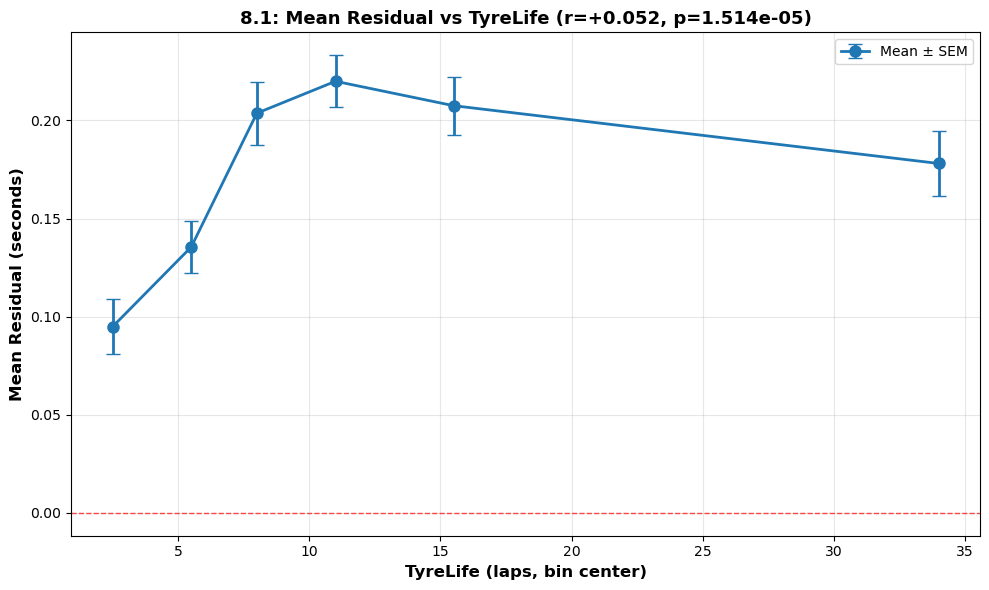

In [40]:
from scipy import stats

# ==============================================================================
# SECTION 8.1: MEAN RESIDUAL vs TYRELIFE BINS
# ==============================================================================

print("\n" + "="*100)
print("SECTION 8.1: MEAN RESIDUAL vs TYRELIFE BINS (Degradation Bias)")
print("="*100)

df_8_1 = pd.DataFrame({'residual': residuals, 'TyreLife': tyrelife}).dropna()

if len(df_8_1) > 0:
    # Correlation
    corr, pval = stats.pearsonr(df_8_1['TyreLife'], df_8_1['residual'])

    try:
        tyrelife_bins = pd.qcut(df_8_1['TyreLife'], q=6, duplicates='drop')
    except (ValueError, TypeError):
        tyrelife_bins = pd.cut(df_8_1['TyreLife'], bins=6, include_lowest=True)
    
   

    # Effect size: check first vs last bin
    bin_data = []
    for bin_label, group in df_8_1.groupby(tyrelife_bins, observed=True):
        bin_data.append({
            'center': (bin_label.left + bin_label.right) / 2,
            'mean': group['residual'].mean(),
            'sem': group['residual'].std() / np.sqrt(len(group))
        })
    bin_df = pd.DataFrame(bin_data)
    
    delta_bias = bin_df['mean'].iloc[-1] - bin_df['mean'].iloc[0]

    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.errorbar(bin_df['center'], bin_df['mean'], yerr=bin_df['sem'],
                fmt='o-', capsize=5, linewidth=2, markersize=8, label='Mean ± SEM')
    ax.axhline(0, color='r', linestyle='--', linewidth=1, alpha=0.7)
    ax.set_xlabel("TyreLife (laps, bin center)", fontweight='bold', fontsize=12)
    ax.set_ylabel("Mean Residual (seconds)", fontweight='bold', fontsize=12)
    ax.set_title(f"8.1: Mean Residual vs TyreLife (r={corr:+.3f}, p={pval:.3e})", 
                 fontweight='bold', fontsize=13)
    ax.grid(alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.savefig("csv_output/linear/tyrelife_bins.pdf", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()




SECTION 8.2: MEAN RESIDUAL BY COMPOUND


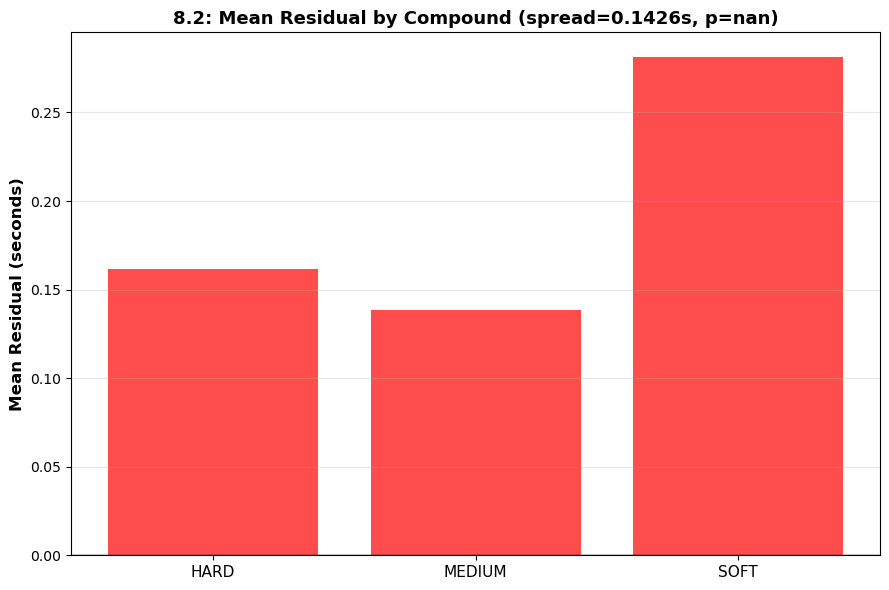

In [41]:

# ==============================================================================
# SECTION 8.2: MEAN RESIDUAL BY COMPOUND
# ==============================================================================

print("\n" + "="*100)
print("SECTION 8.2: MEAN RESIDUAL BY COMPOUND")
print("="*100)

df_8_2 = pd.DataFrame({'residual': residuals, 'Compound': compound}).dropna()

if len(df_8_2) > 0:
    # Per-compound stats
    cmpd_stats = df_8_2.groupby('Compound', observed=True).agg({
        'residual': ['mean', 'std', 'count']
    }).round(6)

    
    compounds = sorted(df_8_2['Compound'].unique())
    compound_means = [df_8_2[df_8_2['Compound'] == c]['residual'].mean() for c in compounds]
    spread = max(compound_means) - min(compound_means)

    
    # ANOVA (only if multiple compounds)
    if len(compounds) > 1:
        groups = [df_8_2[df_8_2['Compound'] == c]['residual'].values for c in compounds]
        f_stat, p_val = stats.f_oneway(*groups)
       
        f_stat, p_val = np.nan, np.nan
    
    # Plot
    colors = ['red' if m > 0 else 'blue' for m in compound_means]
    
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.bar(range(len(compounds)), compound_means, color=colors, alpha=0.7)
    ax.axhline(0, color='k', linewidth=1)
    ax.set_xticks(range(len(compounds)))
    ax.set_xticklabels(compounds, fontsize=11)
    ax.set_ylabel("Mean Residual (seconds)", fontweight='bold', fontsize=12)
    ax.set_title(f"8.2: Mean Residual by Compound (spread={spread:.4f}s, p={p_val:.3e})",
                 fontweight='bold', fontsize=13)
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig("csv_output/linear/compound_means.pdf", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()





VARIANCE vs TYRELIFE BINS (Late-in-Tyre-Life)
(Note: Tests whether residual variance grows as tyre ages)


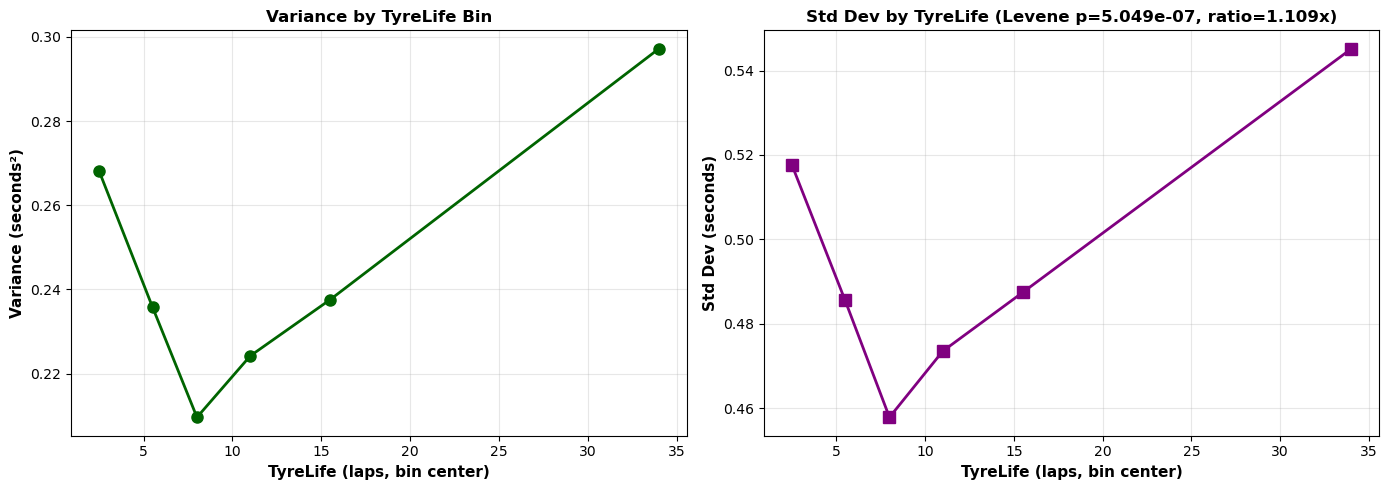

In [42]:

# ==============================================================================
# SECTION 8.3: VARIANCE vs TYRELIFE BINS (Late-in-Stint Degradation)
# ==============================================================================

print("\n" + "="*100)
print("VARIANCE vs TYRELIFE BINS (Late-in-Tyre-Life)")
print("="*100)
print("(Note: Tests whether residual variance grows as tyre ages)")

df_8_3 = pd.DataFrame({'residual': residuals, 'TyreLife': tyrelife}).dropna()

if len(df_8_3) > 0:
    # Bin by TyreLife (quantile bins for robust variance comparison)
    try:
        tyrelife_bins_3 = pd.qcut(df_8_3['TyreLife'], q=6, duplicates='drop')
    except (ValueError, TypeError):
        tyrelife_bins_3 = pd.cut(df_8_3['TyreLife'], bins=6, include_lowest=True)
    

    var_stats = []
    for bin_label, group in df_8_3.groupby(tyrelife_bins_3, observed=True):
        var_stats.append({
            'bin_center': (bin_label.left + bin_label.right) / 2,
            'variance': np.var(group['residual']),
            'std': np.std(group['residual']),
            'n': len(group)
        })
    var_df = pd.DataFrame(var_stats)

    
    # Levene's test
    groups_3 = [df_8_3[tyrelife_bins_3 == b]['residual'].values 
                for b in tyrelife_bins_3.unique()]
    levene_stat, levene_p = stats.levene(*groups_3)

    
    # Effect size: variance ratio
    var_ratio = var_df['variance'].iloc[-1] / var_df['variance'].iloc[0]

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(var_df['bin_center'], var_df['variance'], 'o-', linewidth=2, markersize=8, color='darkgreen')
    ax1.set_xlabel("TyreLife (laps, bin center)", fontweight='bold', fontsize=11)
    ax1.set_ylabel("Variance (seconds²)", fontweight='bold', fontsize=11)
    ax1.set_title("Variance by TyreLife Bin", fontweight='bold', fontsize=12)
    ax1.grid(alpha=0.3)
    
    ax2.plot(var_df['bin_center'], var_df['std'], 's-', linewidth=2, markersize=8, color='purple')
    ax2.set_xlabel("TyreLife (laps, bin center)", fontweight='bold', fontsize=11)
    ax2.set_ylabel("Std Dev (seconds)", fontweight='bold', fontsize=11)
    ax2.set_title(f"Std Dev by TyreLife (Levene p={levene_p:.3e}, ratio={var_ratio:.3f}x)", fontweight='bold', fontsize=12)
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("csv_output/linear/variance_trends.pdf", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

